# Brain Tumor Segmentation Using Basic Unet (Notebook 1)
Nanyan "Rosalie" Zhu & Chen "Raphael" Liu

This notebook belongs to this repository ["RnR-2018/BMEN4460-NB3-brain-tumor-segmentation"](https://github.com/RnR-2018/BMEN4460-NB2-brain_tumor_segmentation) and its parent repository ["RnR-2018/Deep-learning-with-PyTorch-and-GCP"](https://github.com/RnR-2018/Deep-learning-with-PyTorch-and-GCP).

This notebook is inspired by and largely adapted from [this GitHub repository](https://github.com/sdsubhajitdas/Brain-Tumor-Segmentation). It's a pretty well-organized repository with surprisingly few stars. We recommend giving it a star when you have time.

This brain tumor segmentation series, consisting of three jupyter notebooks, will walk you through the essential steps of building up your own project. As you progress along these three notebooks, you will see incremental elements being added and (hopefully) performance being improved. This is the first notebook in this series, and it will introduce you the absurdly elementary but working example. Please don't get disappointed if the performance does not meet your expectation; please learn as much as you can (or laugh at it as much as you want) and stay excited for the better versions.

contents:
  - [Setup](#Setup)
      - [Import packages](#Import-the-necessary-packages)
      - [Set random seed](#Set-the-random-seed-for-reproducibility)
      - [Ser device](#Define-the-computational-device)
  - [Data Preparation](#Data-preparation)
      - [Define our dataset](#Define-our-dataset)
      - [Define the function](#Define-the-functions-to-load-data-and-conduct-train-validation-test-split)
      - [Load the dataset and complete the TVT split](#Load-the-dataset-and-complete-the-TVT-split)
      - [Inspect the data](#Inspect-the-data)
  - [Model and loss function declaration](#Model-and-loss-function-declaration)
  - [Model Training](#Model-Training)
  - [Training Results](#Training-Results)
      - [Training Loss Graph](#Training-Loss-Graph)
      - [Test our model](#Test-our-model)
      - [Prediction Visualization](#Visualize-test-dataset-predictions)

## Setup

### Import the necessary packages

In [1]:
import os
import random
from glob import glob
import warnings
import pickle
warnings.filterwarnings('ignore')

import torch
import torch.optim as optim
from torch.utils.data import Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from time import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch.nn.functional as F
import torch.nn as nn

### Set the random seed for reproducibility

The random seed helps to make sure that the model parameter initialization, sequence of random shuffling, and most other nondeterministic operations are kept the same each time you run this notebook.

In [2]:
torch.manual_seed(4460);
np.random.seed(4460)

### Define the computational device 
This shall automatically use GPU if available, and will use CPU otherwise.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

Computation Details
	Device Used: (cuda)  GeForce GTX 1070

Packages Used Versions:-
	Pytorch Version: 1.4.0


## Data preparation

### Define our dataset
Plan the train-validation-test (TVT) split, and set the hyperparameters.

In [4]:
# Dataset folder used
DATASET_PATH = os.path.join('./dataset/png_dataset')

# We would like to perform a train-validation-test split at the ratio of T:V:T = 6:2:2.
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2

# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Training Epochs
epochs = 20

### Define the functions to load data and conduct train validation test split

In [5]:
class TumorDataset(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion and 2) a resizing to 512 x 512.
        self.default_transformation = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((512, 512))
        ])
        self.DEBUG = DEBUG

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample

        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_name = os.path.join(self.root_dir, str(index) + '.png')
        mask_name = os.path.join(self.root_dir, str(index) + '_mask.png')

        # Use PIL to open the images and masks.
        image = Image.open(image_name)
        mask = Image.open(mask_name)

        # Apply the default transformations on the images and masks.
        image = self.default_transformation(image)
        mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        # Construct the images and masks together in the form of a dictionary.
        sample = {'index': int(index), 'image': image, 'mask': mask}
        return sample

    def __len__(self):
        ''' Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_files = len(glob(os.path.join(self.root_dir, '*.png')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_files % 2 == 0, error_msg + ' total files: %s' % (total_files)
        
        # Return how many image-mask pairs we have.
        return total_files // 2

In [6]:
def get_indices(length, val_split, test_split):
    '''
    Gets the Training & Testing data indices for the dataset.
    Stores the indices and returns them back when the same dataset is used.
    Inputs:
        length(int): Length of the dataset used.
        val_split: the portion (0 to 1) of data used for validation.
        test_split: the portion (0 to 1) of data used for testing.
    Parameters:
        train_indices(list): Array of indices used for training purpose.
        validation_indices(list): Array of indices used for validation purpose.
        test_indices(list): Array of indices used for testing purpose.
    '''
    data = dict()
    indices = list(range(length))
    np.random.shuffle(indices)
    split1 = int(np.floor(test_split * len(tumor_dataset)))
    split2 = split1 + int(np.floor(val_split * len(tumor_dataset)))
    train_indices, validation_indices, test_indices = indices[split2:], indices[split1:split2], indices[:split1]
    return train_indices, validation_indices, test_indices

### Load the dataset and complete the TVT split

In [7]:
tumor_dataset = TumorDataset(DATASET_PATH)

train_indices, validation_indices, test_indices = get_indices(len(tumor_dataset), val_split = VAL_SPLIT, test_split = TEST_SPLIT)
train_sampler, validation_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler = train_sampler)
validationloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = validation_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = test_sampler)

print('Number of files in the train set: %s \nNumber of files in the validation set: %s \nNumber of files in the test set: %s' \
      % (len(train_indices), len(validation_indices), len(test_indices)))

Number of files in the train set: 920 
Number of files in the validation set: 306 
Number of files in the test set: 306


### Inspect the data 
look at some image-mask pairs.

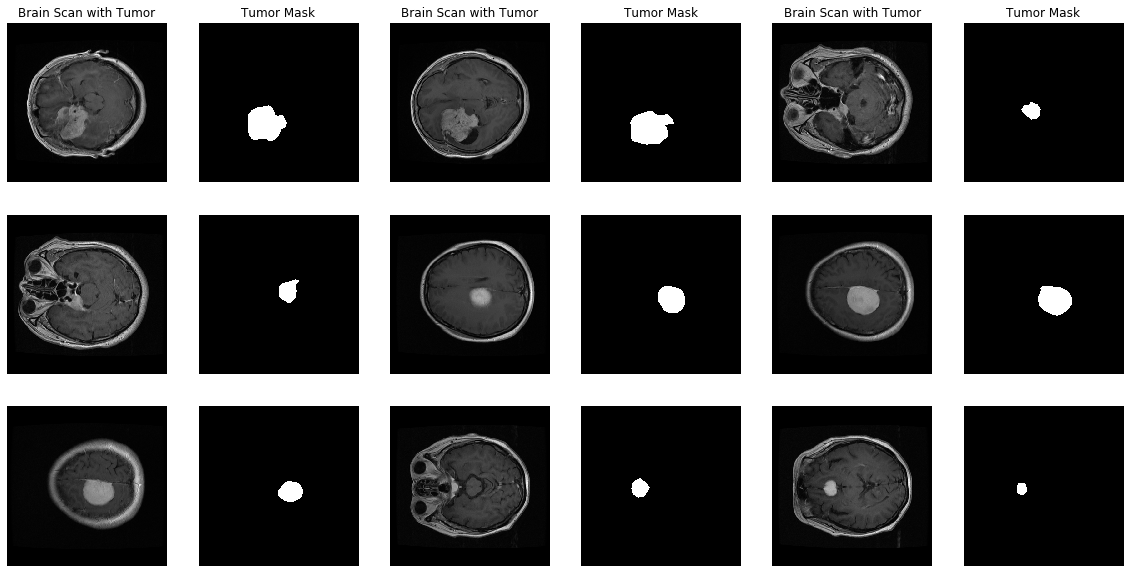

In [8]:
plt.rcParams['figure.figsize'] = [20, 10]

row = 3; col = 6

for image_index in range(1, row * col + 1):
    plt.subplot(row, col, image_index)
    if image_index % 2 == 1:
        image = plt.imread(os.path.join(DATASET_PATH, str(image_index) + '.png'))
    else:
        image = plt.imread(os.path.join(DATASET_PATH, str(image_index) + '_mask.png'))
    if image_index <= col:
        if image_index % 2 == 1:
            plt.title('Brain Scan with Tumor')
        else:
            plt.title('Tumor Mask')
    plt.axis('off')
    plt.imshow(image, cmap = 'gray')

plt.show()

## Model and loss function declaration

### Our Model: U-net
The basic unet architechture is illustrated in the following picture. For more information about U-Net Architecture check the paper [here](https://arxiv.org/abs/1505.04597).

Note that is this notebook, the number of kernels is reduced by 4 times compared to the original unet.
<img src="Unet_architecture.PNG" width="1200" align="center">

In [9]:
class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.ReLU(inplace = True),
            nn.Conv2d(ch_out, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.ReLU(inplace = True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.ReLU(inplace = True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
    
class U_Net(nn.Module):
    '''
    This is the Pytorch version of U-Net Architecture.

    The input and output of this network is of the same shape.
    Input Size of Network - (1,512,512). 
        Note that the input size here is just for our dataset in this notebook, but if you use this network for other projects, any input size that is a multiple of 2 ** 5 will work.
    Output Size of Network - (1,512,512)
        Shape Format :  (Channel, Width, Height)
    '''
    def __init__(self, img_ch = 1, output_ch = 1, first_layer_numKernel = 16):
        '''
        Constructor for UNet class.
        Parameters:
            img_ch(int): Input channels for the network. Default: 1
            output_ch(int): Output channels for the final network. Default: 1
            first_layer_numKernel(int): Number of kernels uses in the first layer of our unet.
        '''
        super(U_Net, self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.Conv1 = conv_block(ch_in = img_ch, ch_out = first_layer_numKernel)
        self.Conv2 = conv_block(ch_in = first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Conv3 = conv_block(ch_in = 2 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Conv4 = conv_block(ch_in = 4 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Conv5 = conv_block(ch_in = 8 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)

        self.Up5 = up_conv(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Up_conv5 = conv_block(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)

        self.Up4 = up_conv(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Up_conv4 = conv_block(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        
        self.Up3 = up_conv(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Up_conv3 = conv_block(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        
        self.Up2 = up_conv(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)
        self.Up_conv2 = conv_block(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)

        self.Conv_1x1 = nn.Conv2d(first_layer_numKernel, output_ch, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        '''
        Method for forward propagation in the network.
        Parameters:
            x(torch.Tensor): Input for the network of size (1, 512, 512).

        Returns:
            output(torch.Tensor): Output after the forward propagation 
                                    of network on the input.
        '''
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
        
        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)
        
        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim = 1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim = 1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim = 1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim = 1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        output = F.sigmoid(d1)

        return output

### Define our evaluation metric: dice coefficient.

In [10]:
def dice_coefficient(predicted, target):
    '''
    Calculates the Sørensen–Dice Coefficient for a single sample.
    Parameters:
        predicted(numpy.ndarray): Predicted single output of the network.
                                Shape - (Channel, Height, Width)
        target(numpy.ndarray): Actual required single output for the network
                                Shape - (Channel, Height, Width)

    Returns:
        coefficient(float): Dice coefficient for the input sample.
                                    1 represents highest similarity and
                                    0 represents lowest similarity.
    '''
    # The smooth term is used to prevent division by zero.
    smooth = 1
    product = np.multiply(predicted, target)
    intersection = np.sum(product)
    coefficient = (2 * intersection + smooth) / (np.sum(predicted) + np.sum(target) + smooth)
    return coefficient

## Model Training

### Get ready for training.

In [11]:
unet_model = None
unet_classifier = None
criterion = nn.BCELoss()
learning_rate = 0.0001

#### If you want to see the training trend within each epoch, you can change mini_batch to a positive integer 
#### that is no larger than the number of batches per epoch.
mini_batch = False

# Define where to save the model parameters.
model_save_path = './saved_models/'
os.makedirs(model_save_path, exist_ok = True)

# New model is created.
unet_model = U_Net().to(device)

#### You can uncomment this to see the textual architecture of our U-Net.
#print(unet_model)

### Start training our U-Net.

In [12]:
# Training session history data.
history = {'train_loss': list(), 'validation_loss': list()}

# For save best feature. Initial loss taken a very high value.
last_score = 0

# Optimizer used for training process. Adam Optimizer.
optimizer = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Reducing LR on plateau feature to improve training.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)

print('Starting Training Process')

assert validationloader.batch_size == 1

# Epoch Loop
for epoch in range(epochs):
    
    #################################### Train ####################################################
    unet_model.train()
    start_time = time()
    # Training a single epoch
    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    validation_score, validation_loss = 0, 0

    for batch, data in enumerate(trainloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Loading data to device used.
        image = data['image'].to(device)
        mask = data['mask'].to(device)
        # Clearing gradients of optimizer.
        optimizer.zero_grad()
        # Calculation predicted output using forward pass.
        output = unet_model(image)
        # Calculating the loss value.
        loss_value = criterion(output, mask)
        # Computing the gradients.
        loss_value.backward()
        # Optimizing the network parameters.
        optimizer.step()
        # Updating the running training loss
        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()

        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * trainloader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0

    train_epoch_loss = train_epoch_loss / (batch_iteration * trainloader.batch_size)
    
    ################################### Validation ##################################################
    unet_model.eval()
    # To get data in loops.
    batch_iteration = 0

    for batch, data in enumerate(validationloader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Data prepared to be given as input to model.
        image = data['image'].to(device)
        mask = data['mask'].to(device)

        # Predicted output from the input sample.
        mask_prediction = unet_model(image)
        
        # comput validation loss
        loss_value = criterion(mask_prediction, mask)
        validation_loss += loss_value.item()
        
        # Threshold elimination.
        mask_prediction = (mask_prediction > 0.5)
        mask_prediction = mask_prediction.cpu().numpy()
        mask = mask.cpu().numpy()

        mask = np.resize(mask, (1, 512, 512))
        mask_prediction = np.resize(mask_prediction, (1, 512, 512))
        # Calculate the dice score for original and predicted image mask.
        validation_score += dice_coefficient(mask_prediction, mask)

    # Calculating the mean score for the whole validation dataset.
    unet_val = validation_score / batch_iteration
    validation_loss = validation_loss / batch_iteration
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')
    print(f'validation score: {unet_val:.5f},  ', end = '')

    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_Unet_epoch_%s.pth' % (str(epoch).zfill(3)))
    torch.save(unet_model.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'Basic_Unet_best_model.pth')
    if  last_score < unet_val:
        torch.save(unet_model.state_dict(), best_model_path)
        last_score = unet_val
        print(f'\tBest model saved at score: {unet_val:.5f}')
    else:
        print()

print(f'Training Finished after {epochs} epoches')

Starting Training Process
Epoch:   1,  train Loss: 0.05112,  validation Loss: 0.06632,  validation score: 0.00046,  current lr:  0.0001 , Time: 60.45 s	Best model saved at score: 0.00046
Epoch:   2,  train Loss: 0.01020,  validation Loss: 0.06083,  validation score: 0.00046,  current lr:  0.0001 , Time: 59.50 s	Best model saved at score: 0.00046
Epoch:   3,  train Loss: 0.00974,  validation Loss: 0.05762,  validation score: 0.00046,  current lr:  0.0001 , Time: 59.93 s	Best model saved at score: 0.00046
Epoch:   4,  train Loss: 0.00943,  validation Loss: 0.05783,  validation score: 0.00046,  current lr:  0.0001 , Time: 59.64 s
Epoch:   5,  train Loss: 0.00911,  validation Loss: 0.05352,  validation score: 0.00214,  current lr:  0.0001 , Time: 60.20 s	Best model saved at score: 0.00214
Epoch:   6,  train Loss: 0.00902,  validation Loss: 0.05171,  validation score: 0.00872,  current lr:  0.0001 , Time: 59.96 s	Best model saved at score: 0.00872
Epoch:   7,  train Loss: 0.00875,  validati

## Training Results

### Training Loss Graph

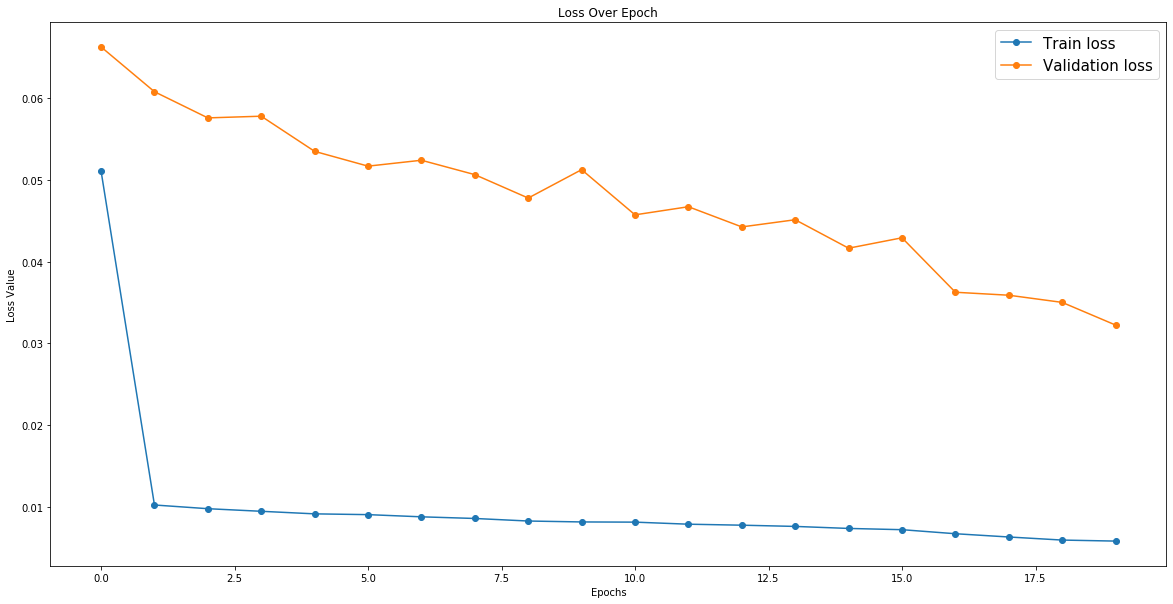

In [17]:
plt.figure(figsize=(20, 10))
plt.title('Loss Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
train_curve = plt.plot(history['train_loss'], marker = 'o', label = 'Train loss')
validation_curve = plt.plot(history['validation_loss'], marker = 'o', label = 'Validation loss')
plt.legend(fontsize = 15)
plt.show()

### Test our model
How does our model perform? Test it out on our test set!

In [18]:
# Load the unet model at its prime (when it performed the best on the validation set).
state_dict = torch.load(os.path.join(model_save_path, 'Basic_Unet_best_model.pth'))
unet_model.load_state_dict(state_dict)

# Testing process on test data.
unet_model.eval()
# Getting test data indices for dataloading
test_data_indexes = test_indices
# Total testing data used.
data_length = len(test_data_indexes)
# Score after testing on dataset.
mean_test_score = 0

for batch, data in enumerate(testloader):
    # Data prepared to be given as input to model.
    image = data['image'].to(device)
    mask = data['mask']

    # Predicted output from the input sample.
    mask_prediction = unet_model(image).cpu()
    # Threshold elimination.
    mask_prediction = (mask_prediction > 0.5)
    mask_prediction = mask_prediction.numpy()

    mask = np.resize(mask, (1, 512, 512))
    mask_prediction = np.resize(mask_prediction, (1, 512, 512))

    # Calculating the dice score for original and predicted mask.
    mean_test_score += dice_coefficient(mask_prediction, mask)

# Calculating the mean score for the whole test dataset.
unet_score = mean_test_score / data_length
# Putting the model back to training mode.
print(f'\nDice Score {unet_score}\n')


Dice Score 0.5658288081591551



Recall what this means: a dice score of 1 is perfect, and 0 is the worst that one can get (well, this statement is not completely accurate because we used a smooth term in the dice coefficient function, and you shall be able to figure out why). A dice score of 0.6 means the model is somewhat functioning, though there is a pretty big area of improvement.

### Visualize test dataset predictions

In [19]:
def result(image, mask, output, title, transparency = 0.38, save_path = None):
    '''
    Plots a 2x3 plot with comparisons of output and original image.
    Works best with Jupyter Notebook/Lab.
    Parameters:
        image(numpy.ndarray): Array containing the original image of MRI scan.
        mask(numpy.ndarray): Array containing the original mask of tumor.
        output(numpy.ndarray): Model predicted mask from input image.
        title(str): Title of the plot to be used.
        transparency(float): Transparency level of mask on images.
                             Default: 0.38
        save_path(str): Saves the plot to the location specified.
                        Does nothing if None. 
                        Default: None
    Return:
        None
    '''

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(
        20, 15), gridspec_kw={'wspace': 0.025, 'hspace': 0.010})
    fig.suptitle(title, x=0.5, y=0.92, fontsize=20)

    axs[0][0].set_title("Original Mask", fontdict={'fontsize': 16})
    axs[0][0].imshow(mask, cmap='gray')
    axs[0][0].set_axis_off()

    axs[0][1].set_title("Predicted Mask", fontdict={'fontsize': 16})
    axs[0][1].imshow(output, cmap='gray')
    axs[0][1].set_axis_off()

    mask_diff = np.abs(np.subtract(mask, output))
    axs[0][2].set_title("Mask Difference", fontdict={'fontsize': 16})
    axs[0][2].imshow(mask_diff, cmap='gray')
    axs[0][2].set_axis_off()

    seg_output = mask*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][0].set_title("Original Segmentation", fontdict={'fontsize': 16})
    axs[1][0].imshow(seg_image, cmap='gray')
    axs[1][0].set_axis_off()

    seg_output = output*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][1].set_title("Predicted Segmentation", fontdict={'fontsize': 16})
    axs[1][1].imshow(seg_image, cmap='gray')
    axs[1][1].set_axis_off()

    axs[1][2].set_title("Original Input Image", fontdict={'fontsize': 16})
    axs[1][2].imshow(image, cmap='gray')
    axs[1][2].set_axis_off()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi = 90, bbox_inches = 'tight')

    plt.show()

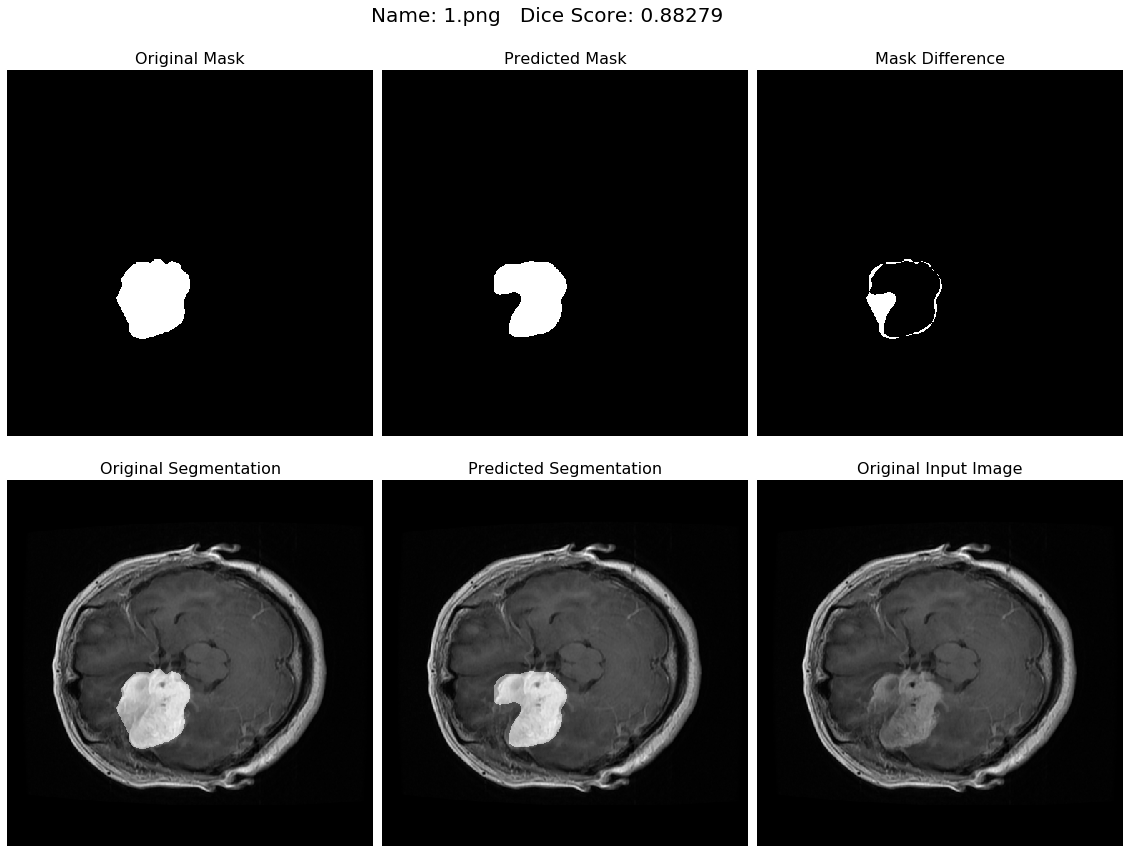

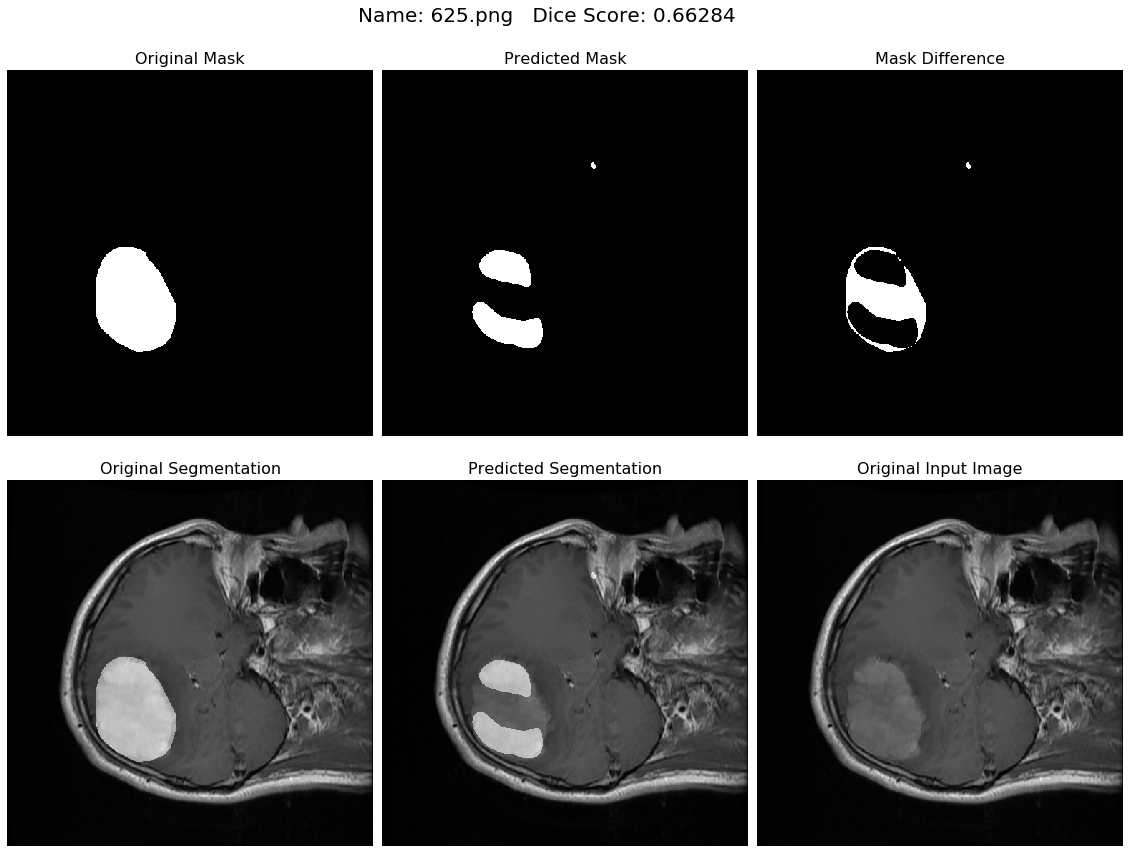

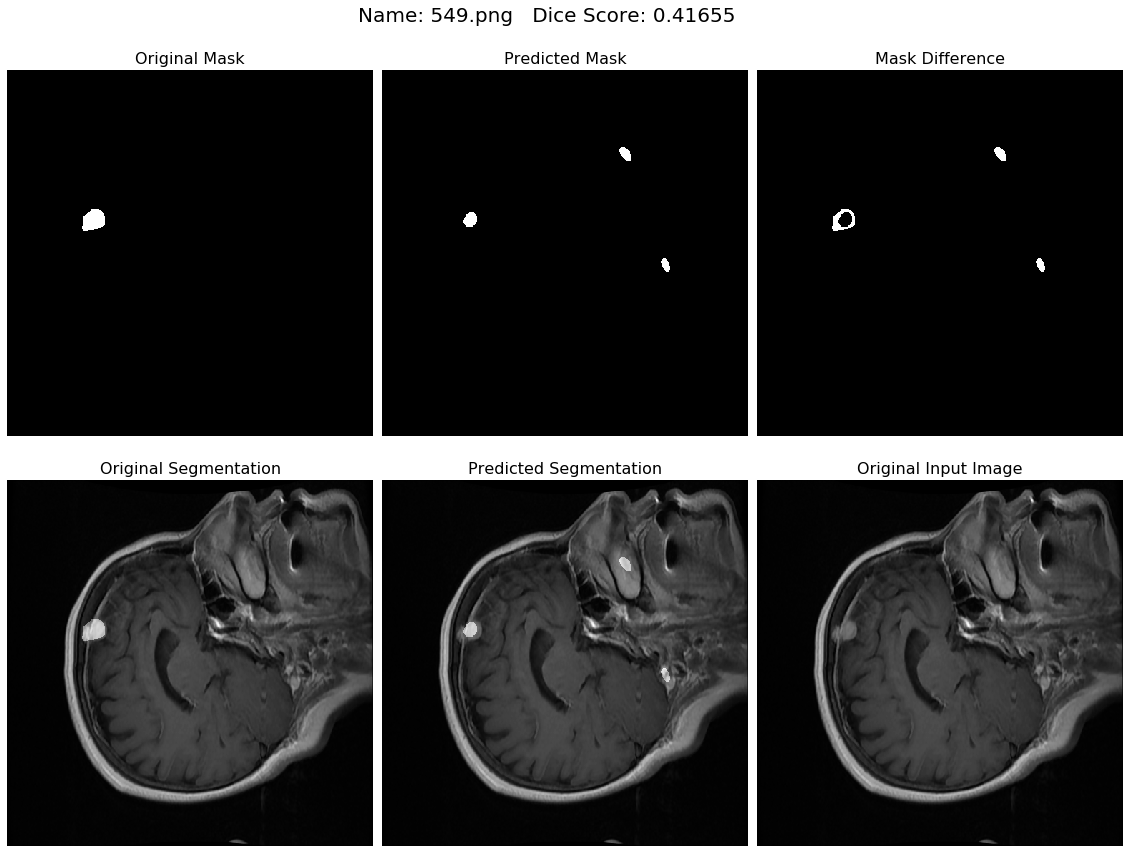

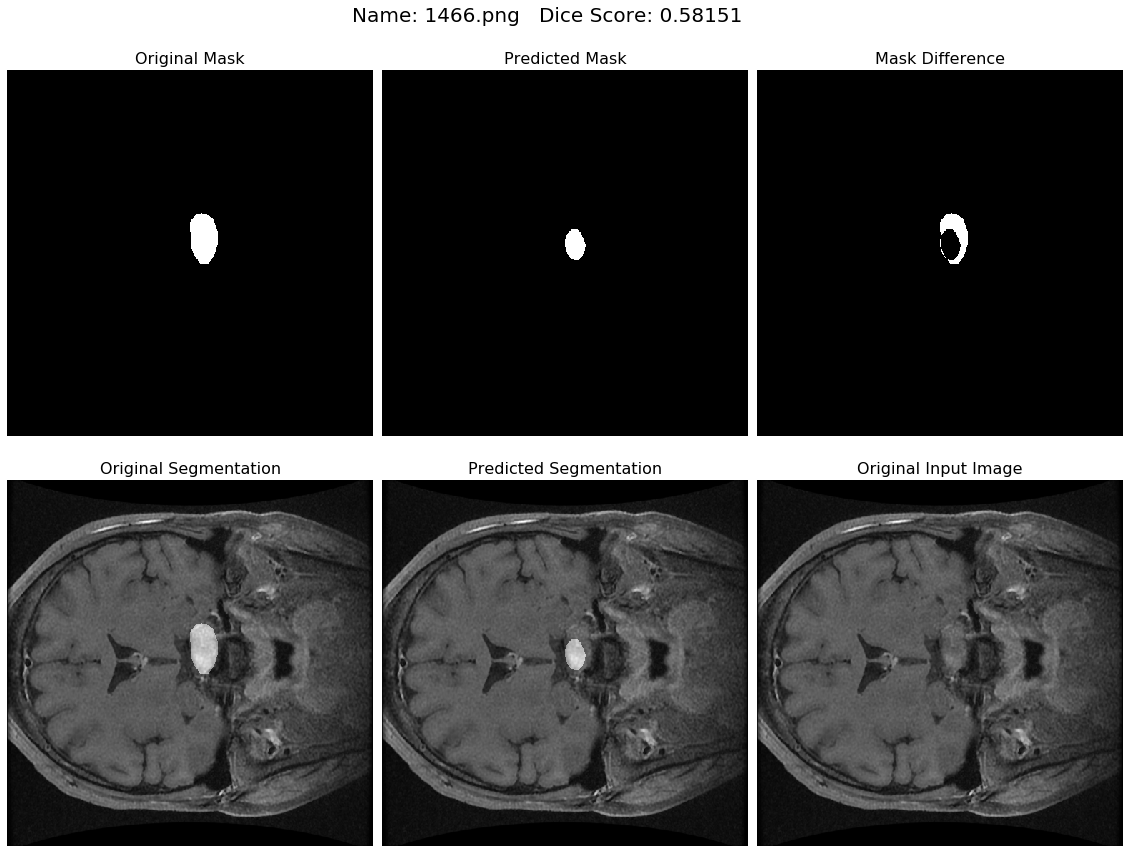

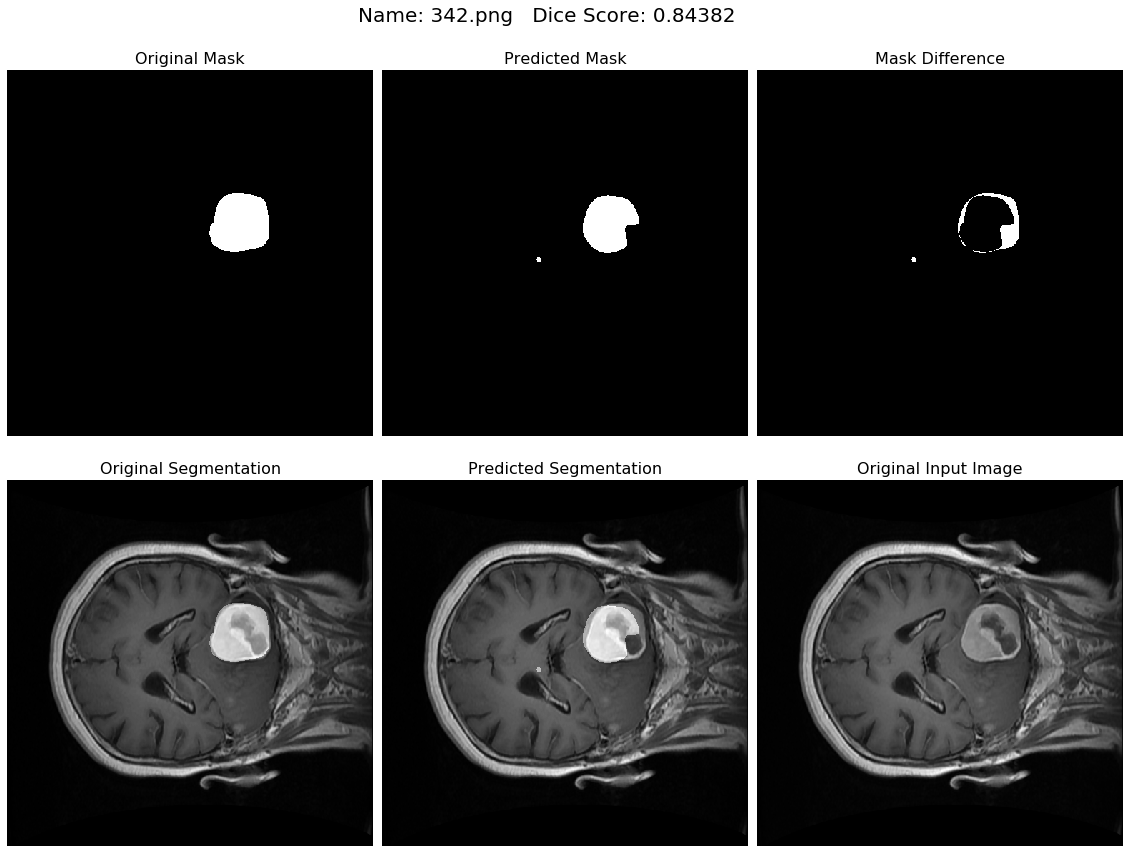

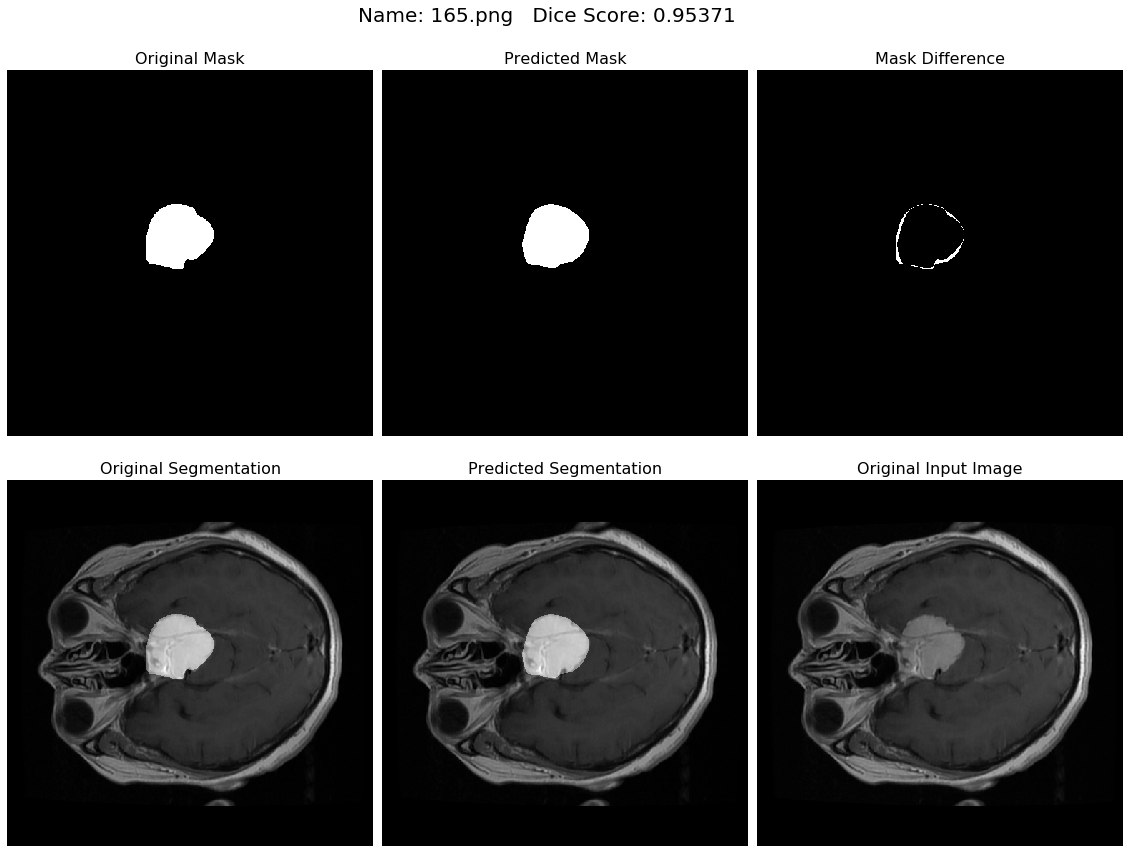

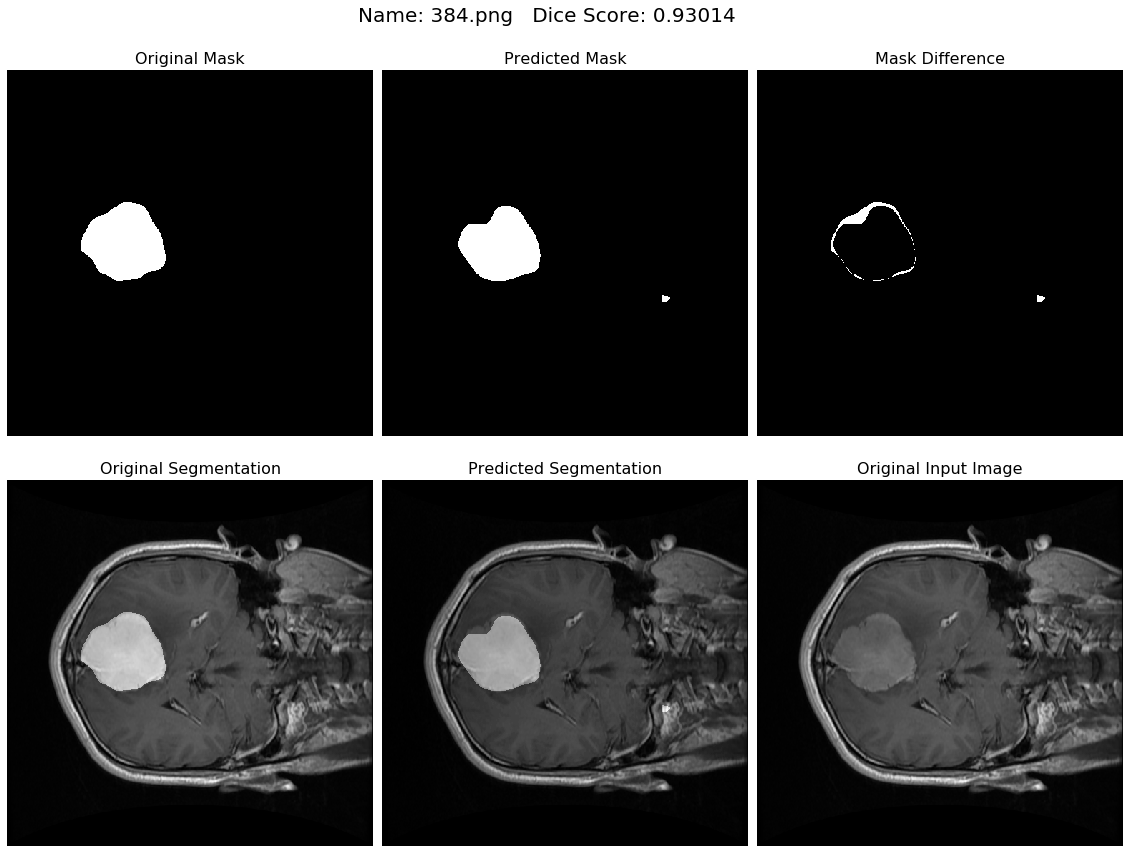

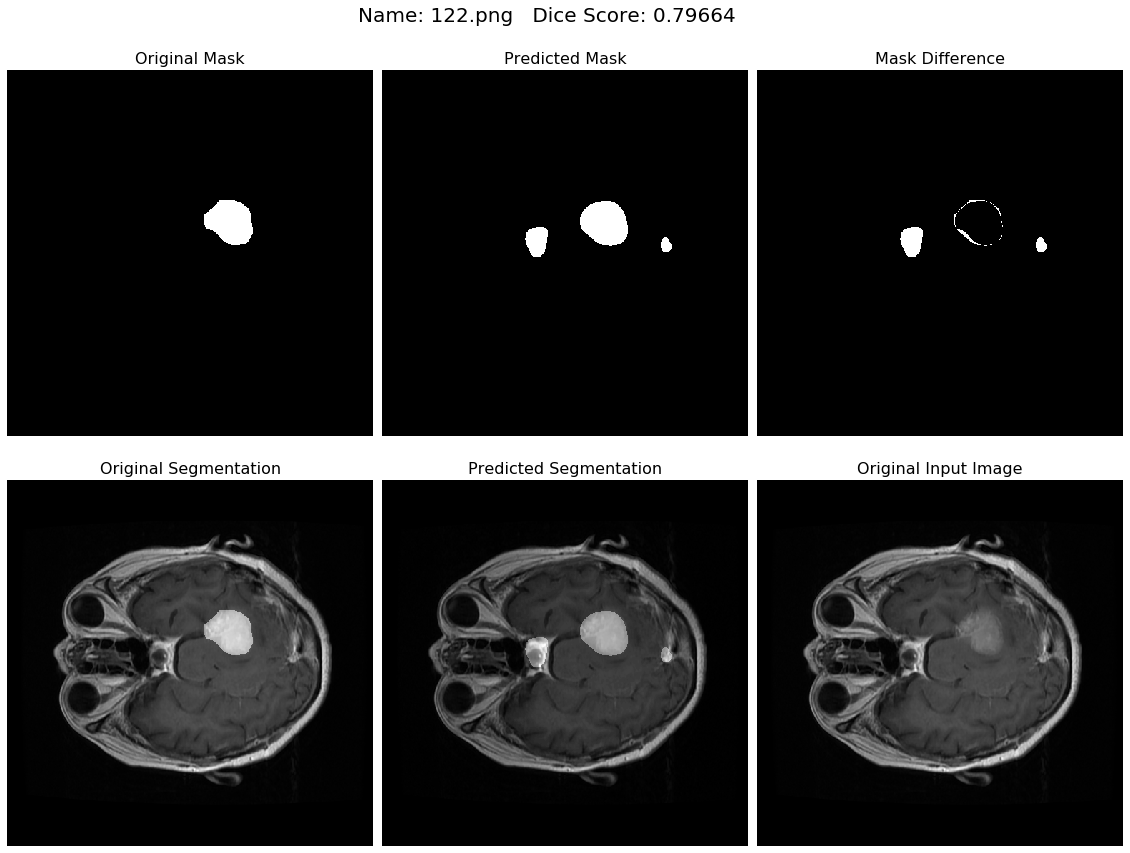

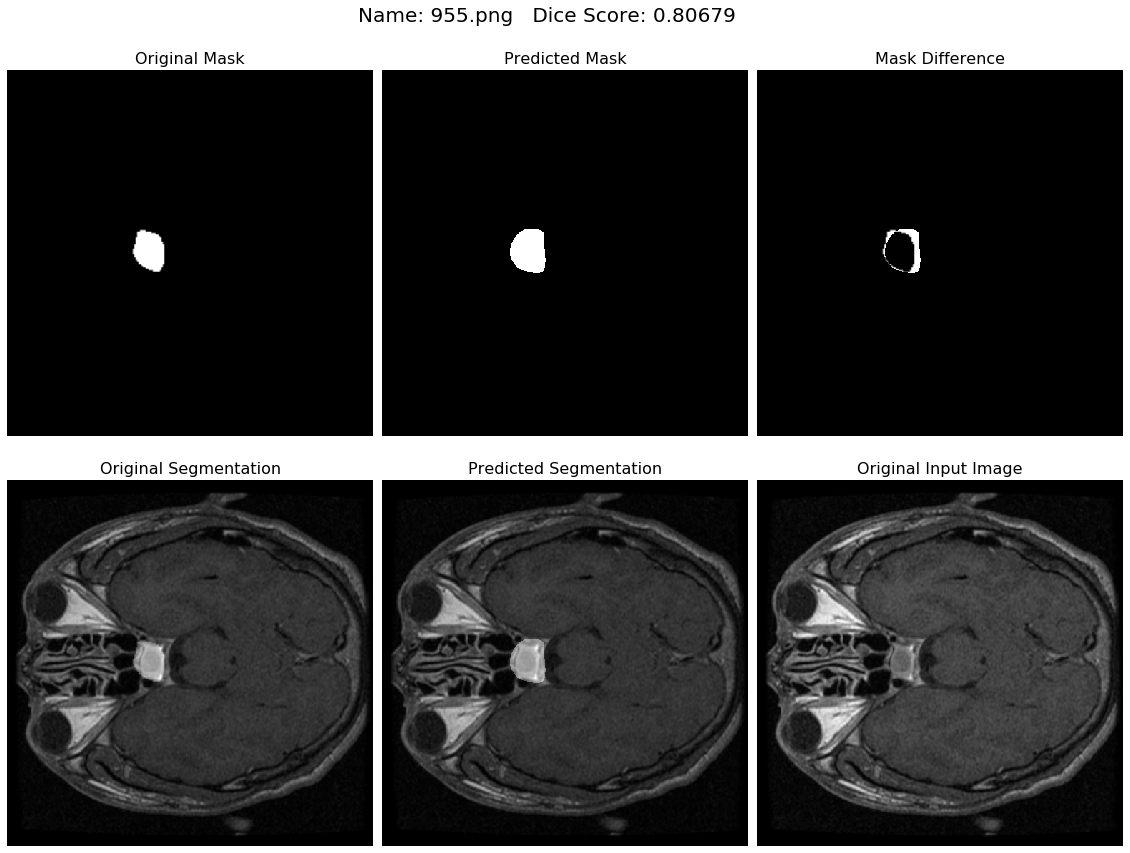

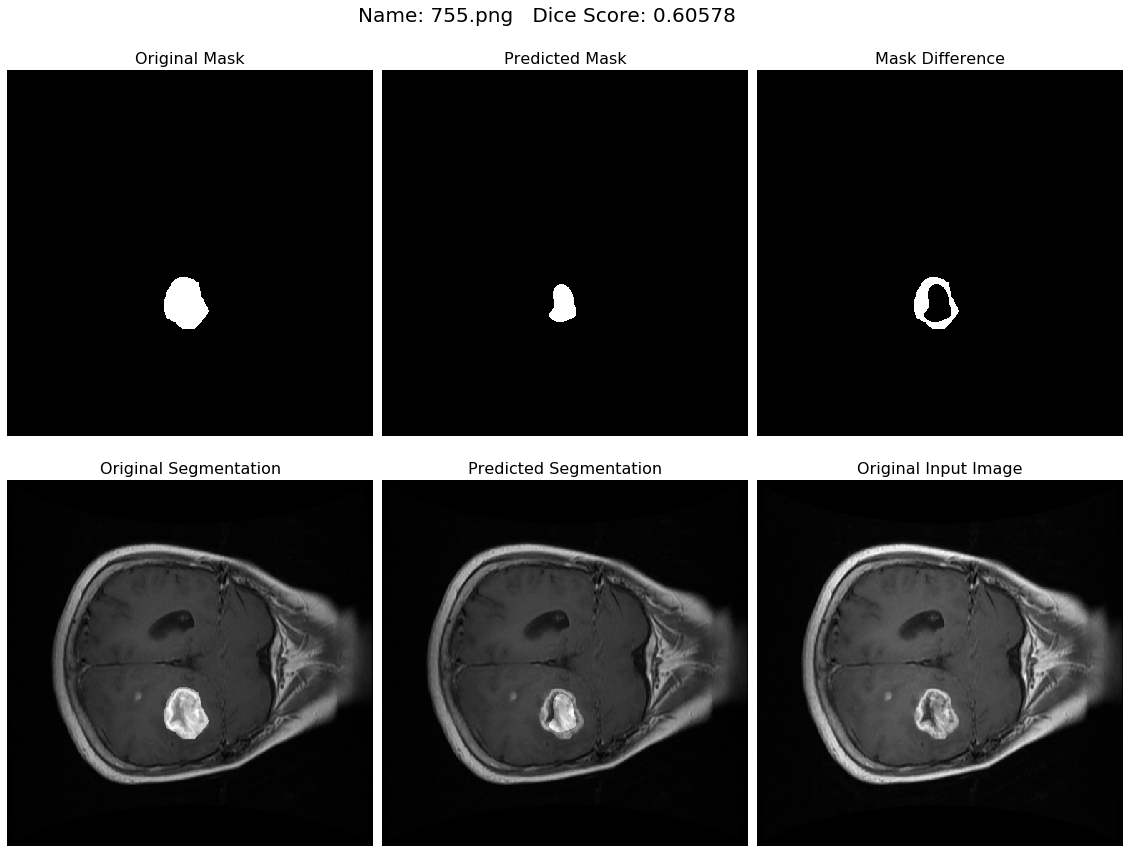

In [20]:
for example_index in range(10):
    # The purpose of image_index is to make sure we truly pick from the test set.
    image_index = test_indices[example_index]
    sample = tumor_dataset[image_index]
    threshold = 0.5

    unet_model.eval()
    image = sample['image'].numpy()
    mask = sample['mask'].numpy()

    image_tensor = torch.Tensor(image)
    image_tensor = image_tensor.view((-1, 1, 512, 512)).to(device)
    output = unet_model(image_tensor).detach().cpu()
    output = (output > threshold)
    output = output.numpy()

    # image(numpy.ndarray): 512x512 Original brain scanned image.
    image = np.resize(image, (512, 512))
    # mask(numpy.ndarray): 512x512 Original mask of scanned image.
    mask = np.resize(mask, (512, 512))
    # output(numpy.ndarray): 512x512 Generated mask of scanned image.
    output = np.resize(output, (512, 512))
    # score(float): Sørensen–Dice Coefficient for mask and output. Calculates how similar are the two images.
    d_score = dice_coefficient(output, mask)

    title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
    # save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
    result(image, mask, output, title, save_path = None)